# Milestone 4 — Unsupervised Model + Clustering

In [9]:
import os
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from typing import List, Dict, Tuple

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams['figure.figsize'] = (7, 5)

In [10]:
DATA_PATH = '../data/raw/games_2016-2024_Milestone3.csv'
df = pd.read_csv(DATA_PATH)
print("Loaded:", df.shape)

target_col = 'home_win'
print("Guessed target column:", target_col)

Loaded: (19436, 29)
Guessed target column: home_win


## Data Cleaning and Feature Engineering

In [ ]:
# Drop outcome-leakers if present (safe no-ops if col doesn't exist)
leakers = [c for c in ['home_runs','away_runs','run_diff','home_score','away_score'] if c in df.columns]
df = df.drop(columns=leakers, errors='ignore')

# Downcast numerics to float32
for c in df.columns:
    if pd.api.types.is_numeric_dtype(df[c]):
        df[c] = pd.to_numeric(df[c], errors='coerce').astype('float32')

# detlas
def _safe_div(a, b):
    r = a / b
    r.replace([np.inf, -np.inf], np.nan, inplace=True)
    r.fillna(0, inplace=True)
    return r

for sfx in ['OPS','ERA','WHIP','BA']:
    h, a = f'home_{sfx}', f'away_{sfx}'
    if (h in df.columns) and (a in df.columns):
        df[f'delta_{sfx.lower()}'] = df[h] - df[a]
        df[f'ratio_{sfx.lower()}'] = _safe_div(df[h], df[a])

if target_col and target_col in df.columns:
    y = df[target_col].astype('int32').values
    X = df.drop(columns=[target_col])
else:
    y = None
    X = df

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if (not pd.api.types.is_numeric_dtype(X[c])) and (X[c].nunique() < 40)]
high_card_cols = [c for c in X.columns if (not pd.api.types.is_numeric_dtype(X[c])) and (X[c].nunique() >= 40)]

print(f"Numeric cols: {len(num_cols)} | Categorical cols (<=40 uniques): {len(cat_cols)} | High-card cols: {len(high_card_cols)}")

X = X.drop(columns=high_card_cols, errors='ignore')
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if (not pd.api.types.is_numeric_dtype(X[c])) and (X[c].nunique() < 40)]


Numeric cols: 26 | Categorical cols (<=40 uniques): 6 | High-card cols: 1


## Train/Test Split

- stratify/ standard 80/20 split.

In [12]:
if y is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
else:
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=RANDOM_STATE)
    y_train = y_test = None

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

Train shape: (15548, 32) | Test shape: (3888, 32)


## Preprocessing Pipeline

- **Numeric**: Standardize for PCA/KMeans stability.  
- **Categorical**: One‑hot encode.  

In [ ]:
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])
categorical_pipe = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

pre = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop",
    sparse_threshold=0.0
)

Xtr = pre.fit_transform(X_train)
Xte = pre.transform(X_test)

print("Xtr shape after preprocessing:", Xtr.shape, "| Xte:", Xte.shape)


Xtr shape after preprocessing: (15548, 100) | Xte: (3888, 100)


## Unsupervised Dimensionality Reduction + Clustering (Fine‑Tuning)

Fine‑tune the hyperparameters using internal cluster validity indices on the training set:
- **Silhouette Score** (higher is better)  
- **Calinski‑Harabasz** (higher is better)  
- **Davies‑Bouldin** (lower is better)

- Search over a grid of PCA components and Clusters K. The best setting is selected by Silhouette (primary), with CH/DB as tie breakers.

In [ ]:
def evaluate_clustering(X, labels):
    if len(np.unique(labels)) < 2:
        return {"silhouette": -1.0, "calinski_harabasz": 0.0, "davies_bouldin": np.inf}
    return {
        "silhouette": float(silhouette_score(X, labels)),
        "calinski_harabasz": float(calinski_harabasz_score(X, labels)),
        "davies_bouldin": float(davies_bouldin_score(X, labels)),
    }

pca_options = [2, 3, 5, 8, 12]
k_options = [2, 3, 4, 5, 6, 8, 10]

best = None
records = []

for ncomp in pca_options:
    pca = PCA(n_components=ncomp, random_state=RANDOM_STATE)
    Xtr_p = pca.fit_transform(Xtr)
    for k in k_options:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
        labels_tr = km.fit_predict(Xtr_p)
        metrics = evaluate_clustering(Xtr_p, labels_tr)
        rec = {"n_components": ncomp, "k": k, **metrics}
        records.append(rec)
        if (best is None) or (metrics["silhouette"] > best["silhouette"]) or (
            math.isclose(metrics["silhouette"], best["silhouette"], rel_tol=1e-6) and
            (metrics["calinski_harabasz"] > best["calinski_harabasz"]) and
            (metrics["davies_bouldin"] < best["davies_bouldin"])
        ):
            best = rec

results_df = pd.DataFrame(records).sort_values(by=["silhouette","calinski_harabasz"], ascending=[False, False]).reset_index(drop=True)
print(best)

{'n_components': 2, 'k': 2, 'silhouette': 0.3431096705410535, 'calinski_harabasz': 9610.223955520052, 'davies_bouldin': 1.124673367024005}


### Selected Hyperparameters

In [15]:
best_ncomp = best["n_components"]
best_k = best["k"]
print(f"Best by Silhouette on train -> n_components={best_ncomp}, k={best_k}")
display(results_df.head(10))

Best by Silhouette on train -> n_components=2, k=2


,n_components,k,silhouette,calinski_harabasz,davies_bouldin
0,2,2,0.343110,9610.223956,1.124673
1,2,3,0.340240,9730.830946,0.954075
2,2,5,0.331021,9761.297530,0.888867
3,2,4,0.327969,9560.788880,0.930368
4,2,10,0.326651,9422.233136,0.834654
5,2,6,0.320712,9455.774186,0.875293
6,2,8,0.315622,9317.266453,0.902255
7,3,2,0.275741,6373.067620,1.379853
8,3,5,0.275404,6577.315602,1.049346
9,3,6,0.273184,6570.975484,1.002632


## Fit Final PCA + KMeans and Compare Train vs Test

In [ ]:
pca_final = PCA(n_components=best_ncomp, random_state=RANDOM_STATE)
Xtr_p = pca_final.fit_transform(Xtr)
Xte_p = pca_final.transform(Xte)

km_final = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init='auto')
labels_tr = km_final.fit_predict(Xtr_p)
labels_te = km_final.predict(Xte_p)

metrics_tr = evaluate_clustering(Xtr_p, labels_tr)
metrics_te = evaluate_clustering(Xte_p, labels_te)

print("TRAIN metrics:", metrics_tr)
print("TEST  metrics:", metrics_te)

TRAIN metrics: {'silhouette': 0.3431096705410535, 'calinski_harabasz': 9610.223955520052, 'davies_bouldin': 1.124673367024005}
TEST  metrics: {'silhouette': 0.33661696076319053, 'calinski_harabasz': 2293.8458247467115, 'davies_bouldin': 1.146879668858788}


### Visualization (First Two PCs)

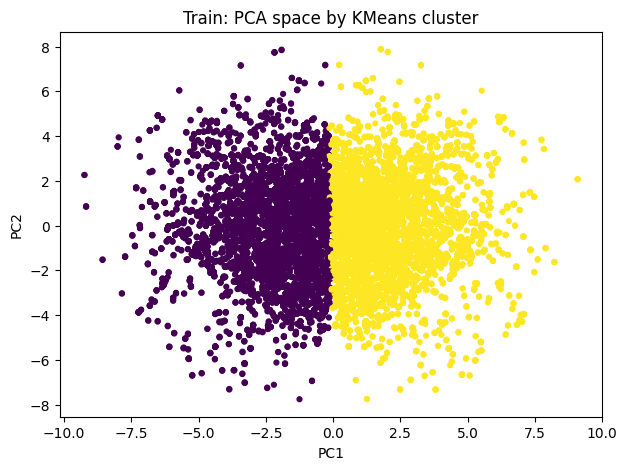

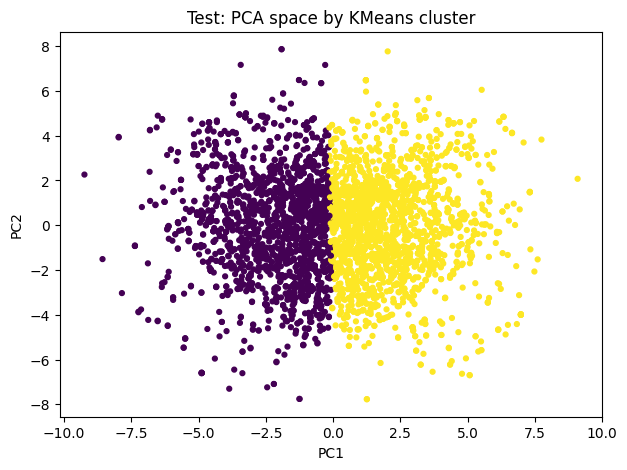

In [ ]:

def scatter_by_clusters(Xp2, labels, title):
    plt.figure()
    plt.scatter(Xp2[:,0], Xp2[:,1], c=labels, s=12)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

if Xtr_p.shape[1] >= 2:
    Xtr_plot = Xtr_p[:, :2]
    Xte_plot = Xte_p[:, :2]
else:
    pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
    Xtr_plot = pca2.fit_transform(Xtr)
    Xte_plot = pca2.transform(Xte)

scatter_by_clusters(Xtr_plot, labels_tr, "Train: PCA space by KMeans cluster")
scatter_by_clusters(Xte_plot, labels_te, "Test: PCA space by KMeans cluster")

## Cluster Outcome

- **Train**: outcome prevalence (e.g., home win rate)  
- **Test**: evaluate a cluster‑conditional predictor that predicts positive if the train cluster rate ≥ 0.5

In [ ]:

def cluster_stats(y_true: np.ndarray, labels: np.ndarray) -> pd.DataFrame:
    # Compute per-cluster positive rate and counts
    df_tmp = pd.DataFrame({"cluster": labels, "y": y_true})
    agg = df_tmp.groupby("cluster").agg(
        n=("y","size"),
        pos=("y","sum")
    ).reset_index()
    agg["pos_rate"] = agg["pos"] / agg["n"].clip(lower=1)
    return agg.sort_values("cluster").reset_index(drop=True)

if y_train is not None:
    train_stats = cluster_stats(y_train, labels_tr)
    # Create cluster-based predictor for TEST
    # Predict 1 if the cluster's train pos_rate >= threshold; default 0.5
    threshold = 0.5
    rate_map = dict(zip(train_stats["cluster"].values, train_stats["pos_rate"].values))
    y_pred_test = np.array([1 if rate_map[c] >= threshold else 0 for c in labels_te], dtype=int)

    print("Per-cluster TRAIN positive rates (used as a rule on TEST):")
    display(train_stats)

    print("\nTEST classification report for cluster-conditional predictor:")
    print(classification_report(y_test, y_pred_test, digits=4))

    cm = confusion_matrix(y_test, y_pred_test, labels=[0,1])
    print("Confusion matrix [[TN, FP],[FN, TP]]:\n", cm)

    acc = accuracy_score(y_test, y_pred_test)
    f1  = f1_score(y_test, y_pred_test)
    pre = precision_score(y_test, y_pred_test)
    rec = recall_score(y_test, y_pred_test)

    print(f"Test Accuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f}")

    df_test_pred = X_test.copy()
    df_test_pred = df_test_pred.reset_index(drop=True)
    df_test_pred['y_true'] = y_test
    df_test_pred['cluster'] = labels_te
    df_test_pred['cluster_train_pos_rate'] = [rate_map[c] for c in labels_te]
    df_test_pred['y_pred'] = y_pred_test
    df_test_pred['correct'] = (df_test_pred['y_true'] == df_test_pred['y_pred']).astype(int)
    df_test_pred['error_type'] = np.where(
        df_test_pred['correct'] == 1,
        np.where(df_test_pred['y_true'] == 1, 'TP', 'TN'),
        np.where(df_test_pred['y_pred'] == 1, 'FP', 'FN')
    )

    out_csv = "outputs/m4_clustered_test_predictions.csv"
    df_test_pred.to_csv(out_csv, index=False)
    print(f"Saved test predictions with FP/FN/TN/TP tags -> {out_csv}")

else:
    print("No binary outcome detected. Skipping cluster-conditional predictor and supervised evaluation.")

Per-cluster TRAIN positive rates (used as a rule on TEST):


,cluster,n,pos,pos_rate
0,0,7465,3290,0.440723
1,1,8083,4952,0.612644



TEST classification report for cluster-conditional predictor:
              precision    recall  f1-score   support

           0     0.5465    0.5698    0.5579      1827
           1     0.6036    0.5808    0.5920      2061

    accuracy                         0.5756      3888
   macro avg     0.5750    0.5753    0.5749      3888
weighted avg     0.5768    0.5756    0.5760      3888

Confusion matrix [[TN, FP],[FN, TP]]:
 [[1041  786]
 [ 864 1197]]
Test Accuracy: 0.5756 | F1: 0.5920 | Precision: 0.6036 | Recall: 0.5808
Saved test predictions with FP/FN/TN/TP tags -> outputs/m4_clustered_test_predictions.csv


## Model Placement on the Fitting Graph & Next Steps

- **Fitting graph position**: We compare **train vs. test** internal metrics. If train >> test (e.g., much higher silhouette), the model may be **overfitting** cluster boundaries. If both are low, we may be **underfitting** (clusters not well-defined).  

In [25]:

summary = {
    "best_n_components": int(best_ncomp),
    "best_k": int(best_k),
    "train_metrics": metrics_tr,
    "test_metrics":  metrics_te
}
print(json.dumps(summary, indent=2))

print("\nInterpretation Hints:")
if metrics_tr["silhouette"] - metrics_te["silhouette"] > 0.05:
    print("- Train silhouette noticeably higher than test ⇒ possible overfitting / unstable clusters across splits.")
elif metrics_te["silhouette"] > metrics_tr["silhouette"]:
    print("- Test silhouette ≥ train ⇒ encouraging generalization / stable structure.")
else:
    print("- Train and test silhouettes are similar ⇒ stable clustering boundaries.")

{
  "best_n_components": 2,
  "best_k": 2,
  "train_metrics": {
    "silhouette": 0.3431096705410535,
    "calinski_harabasz": 9610.223955520052,
    "davies_bouldin": 1.124673367024005
  },
  "test_metrics": {
    "silhouette": 0.33661696076319053,
    "calinski_harabasz": 2293.8458247467115,
    "davies_bouldin": 1.146879668858788
  }
}

Interpretation Hints:
- Train and test silhouettes are similar ⇒ stable clustering boundaries.
